# ArchR Integration

scATAC + scRNA integration using ArchR.

**TODO**: Run with right set of cells!! And use SnapATAC dim reduction!

In [119]:
library(Seurat)
library(ArchR)
library(rtracklayer)
library(patchwork)

In [2]:
addArchRThreads(threads = 32) 

Setting default number of Parallel threads to 32.



In [3]:
addArchRGenome("hg38")

Setting default genome to Hg38.



## Load Data

In [4]:
ArrowFiles = c('D0.arrow',
               'D2.arrow',
               'D4.arrow',
               'D6.arrow',
               'D8.arrow',
               'D10.arrow',
               'D12.arrow',
               'D14.arrow')
#              'H1.arrow')

In [5]:
archr_proj <- ArchRProject(
  ArrowFiles = paste("/srv/scratch/surag/scATAC-reprog/arrow/", ArrowFiles, sep=''), 
  outputDirectory = "./tmp/",
  copyArrows = FALSE #This is recommened so that you maintain an unaltered copy for later usage.
)

Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

Validating Arrows...

Getting SampleNames...



Getting Cell Metadata...



Merging Cell Metadata...

Initializing ArchRProject...


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,-

### Seurat Object

In [6]:
rna = readRDS("../20200828_RNA_Seurat/sessions/20200913_n59369/seurat.rds")
rna$tech = "rna"

In [7]:
peak_set = import("../20200206_pmat_snapATAC/sessions/20201022_n53906/peaks.bed")
peak_set

GRanges object with 414473 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1       10269-10885      *
       [2]     chr1       41989-42505      *
       [3]     chr1       46059-46558      *
       [4]     chr1       48201-48959      *
       [5]     chr1       51307-52190      *
       ...      ...               ...    ...
  [414469]     chrY 25399011-25399553      *
  [414470]     chrY 25410562-25411061      *
  [414471]     chrY 26220959-26221458      *
  [414472]     chrY 26315009-26315508      *
  [414473]     chrY 26670871-26671408      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [13]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200206_pmat_snapATAC/sessions/20201022_n53906/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
dim(metaData)
head(metaData, 5)

[1] 53906     6

barcode          sample umap1    umap2     cluster
D0_AACGCGAGAAGGACCA AACGCGAGAAGGACCA D0     8.373301 -4.292619 5      
D0_AACGCGCTGTCTGTGA AACGCGCTGTCTGTGA D0     2.033609 -7.860645 5      
D0_ACCTATGGACTCGATA ACCTATGGACTCGATA D0     3.093788 -7.469210 5      
D0_ACGCAGAGATAACCCA ACGCAGAGATAACCCA D0     6.001364 -7.523576 5      
D0_ACTCGCTACTTGTGAC ACTCGCTACTTGTGAC D0     3.343237 -8.114589 5      
                    cells              
D0_AACGCGAGAAGGACCA D0_AACGCGAGAAGGACCA
D0_AACGCGCTGTCTGTGA D0_AACGCGCTGTCTGTGA
D0_ACCTATGGACTCGATA D0_ACCTATGGACTCGATA
D0_ACGCAGAGATAACCCA D0_ACGCAGAGATAACCCA
D0_ACTCGCTACTTGTGAC D0_ACTCGCTACTTGTGAC

In [24]:
atac.feats = read.table("../20200206_pmat_snapATAC/sessions/20201022_n53906/features.8d.tsv", sep='\t', header=T)
rownames(atac.feats) = atac.feats$sample_barcode
atac.feats$sample_barcode = NULL
head(atac.feats)

X1          X2            X3          X4           
D0_AACGCGAGAAGGACCA 0.009759640 -0.0029036025 0.005950758 -0.0044482143
D0_AACGCGCTGTCTGTGA 0.010014906 -0.0009976648 0.004592340  0.0001449247
D0_ACCTATGGACTCGATA 0.007803995 -0.0019239757 0.006072189  0.0013185297
D0_ACGCAGAGATAACCCA 0.010130213 -0.0023575190 0.005914786 -0.0010926832
D0_ACTCGCTACTTGTGAC 0.011736855 -0.0037956431 0.005868645 -0.0015166958
D0_AGACTACTGGCAGTTT 0.010725195 -0.0031629527 0.005677750 -0.0007386599
                    X5            X6            X7           X8          
D0_AACGCGAGAAGGACCA  0.0055091063 -0.0241857513 -0.005330782 -0.004719662
D0_AACGCGCTGTCTGTGA -0.0071558476  0.0007937744 -0.012955280 -0.008186943
D0_ACCTATGGACTCGATA -0.0033775435 -0.0034617180 -0.008737580 -0.007854599
D0_ACGCAGAGATAACCCA -0.0024066742 -0.0137149582 -0.008479545 -0.007838299
D0_ACTCGCTACTTGTGAC -0.0060397978 -0.0059278263 -0.014611093 -0.001410683
D0_AGACTACTGGCAGTTT -0.0002972977 -0.0165444186 -0.008667135 -0.006958556

In [17]:
# subset to cells used
all(sub("_", "#", rownames(metaData)) %in% archr_proj$cellNames)

[1] TRUE

In [22]:
archr_proj = archr_proj[sub("_", "#", rownames(metaData)), ]

In [23]:
archr_proj


           ___      .______        ______  __    __  .______      
          /   \     |   _  \      /      ||  |  |  | |   _  \     
         /  ^  \    |  |_)  |    |  ,----'|  |__|  | |  |_)  |    
        /  /_\  \   |      /     |  |     |   __   | |      /     
       /  _____  \  |  |\  \\___ |  `----.|  |  |  | |  |\  \\___.
      /__/     \__\ | _| `._____| \______||__|  |__| | _| `._____|
    



class: ArchRProject 
outputDirectory: /users/surag/kundajelab/scATAC-reprog/src/analysis/20200925_Peak2Gene/tmp 
samples(8): D0 D2 ... D12 D14
sampleColData names(1): ArrowFiles
cellColData names(15): Sample TSSEnrichment ... ReadsInPeaks FRIP
numberOfCells(1): 53906
medianTSS(1): 10.204
medianFrags(1): 8133.5

## ArchR Prep

In [8]:
# add peaks matrix 
archr_proj = addPeakSet(archr_proj, peak_set)
archr_proj <- addPeakMatrix(archr_proj)

ArchR logging to : ArchRLogs/ArchR-addPeakMatrix-1e95719cc42b-Date-2020-11-13_Time-02-47-27.log
If there is an issue, please report to github with logFile!

2020-11-13 02:47:28 : Batch Execution w/ safelapply!, 0 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-addPeakMatrix-1e95719cc42b-Date-2020-11-13_Time-02-47-27.log



In [9]:
getAvailableMatrices(archr_proj)

[1] "GeneIntegrationMatrix" "GeneScoreMatrix"       "PeakMatrix"           
[4] "TileMatrix"

In [25]:
archr_proj <- addIterativeLSI(
    ArchRProj = archr_proj,
    useMatrix = "PeakMatrix", 
    name = "IterativeLSI", 
    iterations = 2, 
    clusterParams = list( #See Seurat::FindClusters
        resolution = c(0.2), 
        sampleCells = 10000, 
        n.start = 10
    ), 
    varFeatures = 25000, 
    dimsToUse = 1:30
)

Checking Inputs...

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-1e955278a715-Date-2020-11-13_Time-03-10-54.log
If there is an issue, please report to github with logFile!

2020-11-13 03:10:59 : Computing Total Accessibility Across All Features, 0.051 mins elapsed.

2020-11-13 03:11:05 : Computing Top Features, 0.15 mins elapsed.

###########
2020-11-13 03:11:05 : Running LSI (1 of 2) on Top Features, 0.151 mins elapsed.
###########

2020-11-13 03:11:05 : Sampling Cells (N = 10004) for Estimated LSI, 0.152 mins elapsed.

2020-11-13 03:11:05 : Creating Sampled Partial Matrix, 0.152 mins elapsed.

2020-11-13 03:11:17 : Computing Estimated LSI (projectAll = FALSE), 0.35 mins elapsed.

2020-11-13 03:12:29 : Identifying Clusters, 1.541 mins elapsed.

2020-11-13 03:12:49 : Identified 4 Clusters, 1.885 mins elapsed.

2020-11-13 03:12:49 : Saving LSI Iteration, 1.885 mins elapsed.

Warning message:
“Use of `dfMean$color` is discouraged. Use `color` instead.”
Warning message:
“Use of `dfM

In [40]:
archr_proj <- addUMAP(ArchRProj = archr_proj, reducedDims = "IterativeLSI")

03:29:05 UMAP embedding parameters a = 0.7669 b = 1.223

03:29:05 Read 53906 rows and found 30 numeric columns

03:29:05 Using Annoy for neighbor search, n_neighbors = 40

03:29:05 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

03:29:14 Writing NN index file to temp file /tmp/Rtmpol0kcf/file1e95f6f8ee4

03:29:14 Searching Annoy index using 28 threads, search_k = 4000

03:29:15 Annoy recall = 100%

03:29:16 Commencing smooth kNN distance calibration using 28 threads

03:29:20 Initializing from normalized Laplacian + noise

03:29:24 Commencing optimization for 200 epochs, with 3392768 positive edges

03:30:02 Optimization finished



In [45]:
archr_proj$Clusters = factor(metaData$cluster)

In [42]:
# archr_proj <- addClusters(input = archr_proj, reducedDims = "IterativeLSI")

In [46]:
p1 <- plotEmbedding(ArchRProj = archr_proj, colorBy = "cellColData", name = "Sample", embedding = "UMAP")
p2 <- plotEmbedding(ArchRProj = archr_proj, colorBy = "cellColData", name = "Clusters", embedding = "UMAP")

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-1e955862b949-Date-2020-11-13_Time-03-32-34.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-1e955862b949-Date-2020-11-13_Time-03-32-34.log



Warning message:
“Use of `dfMean$color` is discouraged. Use `color` instead.”
Warning message:
“Use of `dfMean$color` is discouraged. Use `color` instead.”
Warning message:
“Use of `dfMean$color` is discouraged. Use `color` instead.”
Warning message:
“Use of `dfMean$color` is discouraged. Use `color` instead.”
Warning message:
“Use of `dfMean$color` is discouraged. Use `color` instead.”
Warning message:
“Use of `dfMean$color` is discouraged. Use `color` instead.”
Warning message:
“Use of `dfMean$color` is discouraged. Use `color` instead.”
Warning message:
“Use of `dfMean$color` is discouraged. Use `color` instead.”
Warning message:
“Use of `dfMean$color` is discouraged. Use `color` instead.”
Warning message:
“Use of `dfMean$color` is discouraged. Use `color` instead.”
Warning message:
“Use of `dfMean$color` is discouraged. Use `color` instead.”
Warning message:
“Use of `dfMean$color` is discouraged. Use `color` instead.”
Warning message:
“Use of `dfMean$color` is discouraged. Use `col

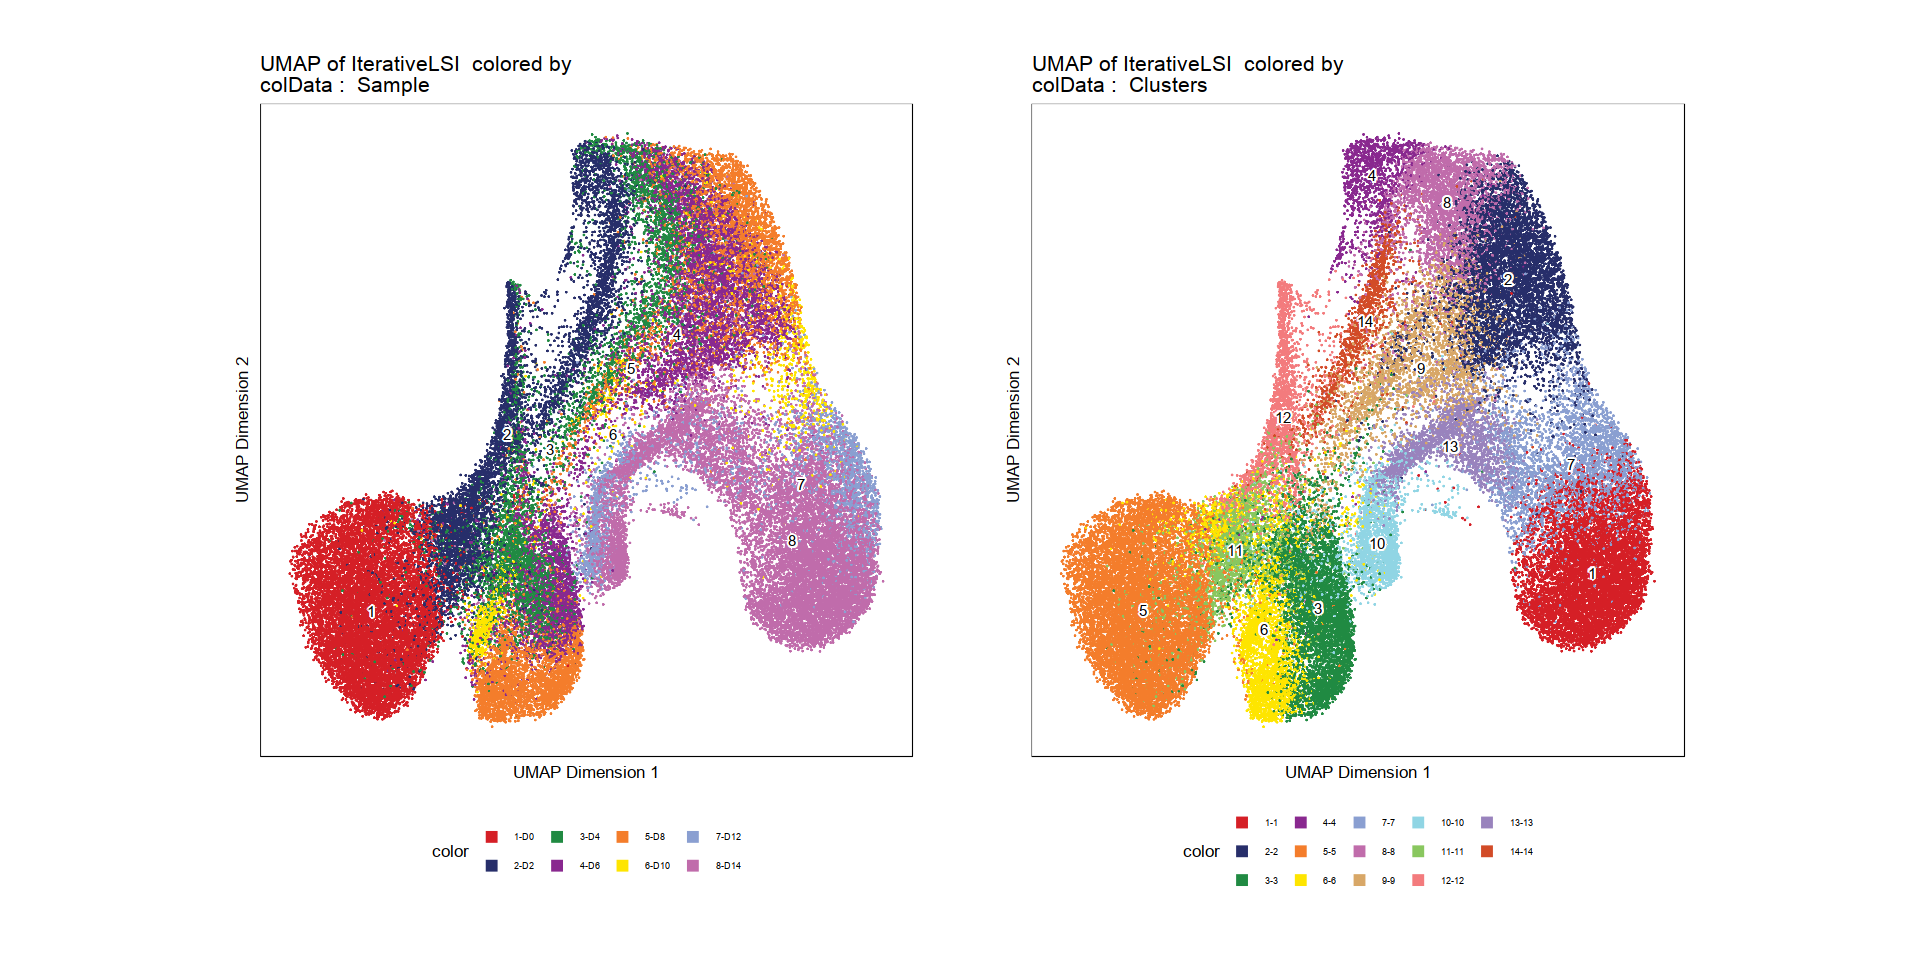

In [47]:
options(repr.plot.width = 16, repr.plot.height = 8)

p1 | p2

## Integration

In [48]:
archr_proj <- addGeneIntegrationMatrix(
    ArchRProj = archr_proj, 
    useMatrix = "GeneScoreMatrix",
    matrixName = "GeneIntegrationMatrix",
    reducedDims = "IterativeLSI",
    seRNA = rna,
    addToArrow = T,
    groupRNA = "seurat_clusters",
    nameCell = "predictedCell_Un",
    nameGroup = "predictedGroup_Un",
    nameScore = "predictedScore_Un",
    force = T
)

ArchR logging to : ArchRLogs/ArchR-addGeneIntegrationMatrix-1e955246f437-Date-2020-11-13_Time-03-34-23.log
If there is an issue, please report to github with logFile!

2020-11-13 03:34:25 : Running Seurat's Integration Stuart* et al 2019, 0.026 mins elapsed.

2020-11-13 03:34:28 : Checking ATAC Input, 0.077 mins elapsed.

2020-11-13 03:34:28 : Checking RNA Input, 0.077 mins elapsed.

2020-11-13 03:34:40 : Creating Integration Blocks, 0.276 mins elapsed.

2020-11-13 03:34:42 : Prepping Interation Data, 0.314 mins elapsed.

2020-11-13 03:34:46 : Computing Integration in 5 Integration Blocks!, 0 mins elapsed.

2020-11-13 03:41:36 : Transferring Data to ArrowFiles, 6.835 mins elapsed.

2020-11-13 03:48:25 : Completed Integration with RNA Matrix, 13.654 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-addGeneIntegrationMatrix-1e955246f437-Date-2020-11-13_Time-03-34-23.log



In [49]:
getAvailableMatrices(archr_proj)

[1] "GeneIntegrationMatrix" "GeneScoreMatrix"       "PeakMatrix"           
[4] "TileMatrix"

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


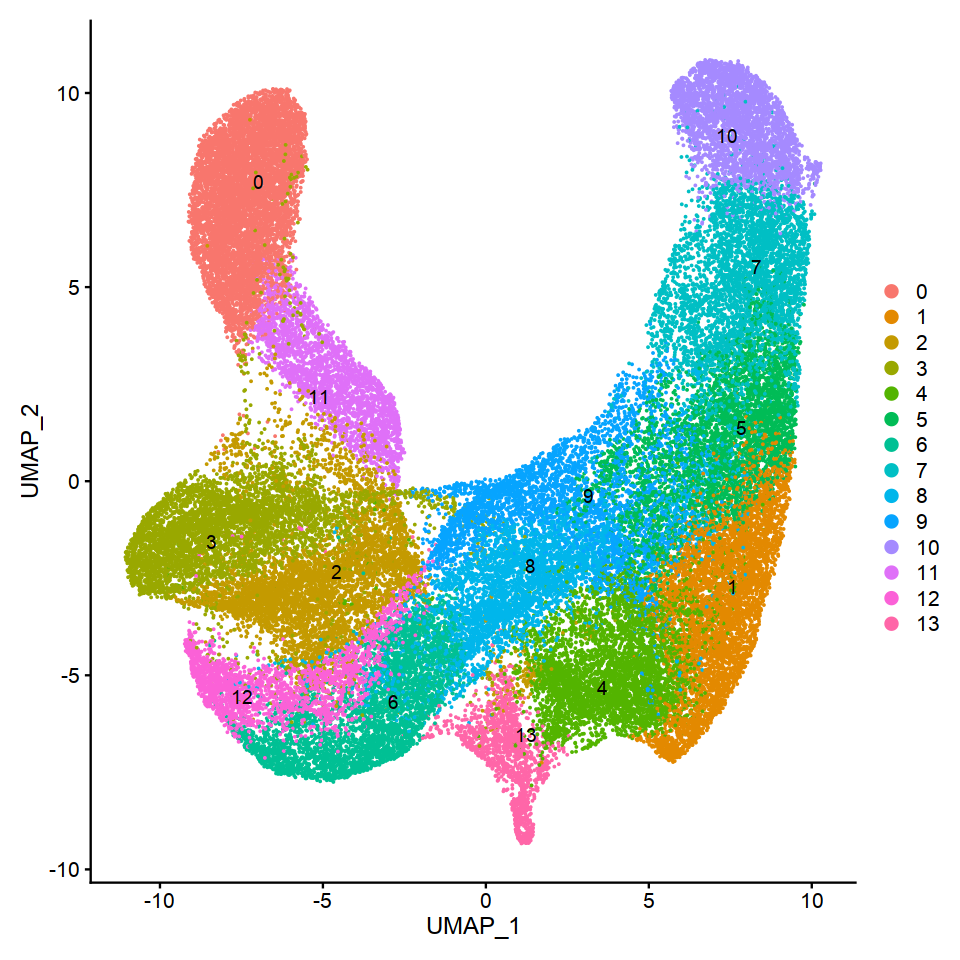

In [50]:
options(repr.plot.width = 8, repr.plot.height = 8)

DimPlot(rna, group.by="seurat_clusters", label=T, repel=T) 

In [51]:
cM <- as.matrix(confusionMatrix(archr_proj$Clusters, archr_proj$predictedGroup_Un))
preClust <- colnames(cM)[apply(cM, 1 , which.max)]
cbind(preClust, rownames(cM)) #Assignments

preClust   
 [1,] 0        5 
 [2,] 0        11
 [3,] 6        6 
 [4,] 3        3 
 [5,] 13       12
 [6,] 9        9 
 [7,] 1        2 
 [8,] 7        7 
 [9,] 12       10
[10,] 9        13
[11,] 1        8 
[12,] 10       1 
[13,] 4        14
[14,] 4        4

In [52]:
head(rev(sort(table(archr_proj$predictedCell_Un))), 20)


ATCATTCTCTACTGCC-1 TCTCCGAGTTCAATCG-1 GTTGTAGCAATCTCTT-1 GCAGCCATCGAGTACT-1 
               717                601                530                417 
TCTCCGATCCACACCT-8 TCTACATTCACCTTAT-8 TTCGATTAGGGAGTGG-1 CTCCCAACAACGACAG-8 
               386                379                361                346 
GGGCTACTCTCCCAAC-8 GCGTGCACAGCACGAA-1 GGAGATGCAAAGCTAA-5 TCTTTGAAGCCATCCG-1 
               316                309                272                260 
GAAGGACAGTAAACGT-1 CGTGATACACAAGTTC-5 GATAGAAAGCCAGAGT-1 TATATCCCATGAGTAA-1 
               258                251                230                229 
CTTCTAATCGTGCATA-1 AGTAACCGTCAGGTAG-4 GGGTATTGTGACACGA-3 TATTGCTGTCCATACA-1 
               229                228                227                223 

In [56]:
BARCODE = "TCTCCGATCCACACCT-8"

In [57]:
umap_dims = archr_proj@embeddings$UMAP$df
colnames(umap_dims) = c("UMAP1", "UMAP2")
umap_dims$col = archr_proj$predictedCell_Un %in% c(BARCODE)
umap_dims$sz = ifelse(umap_dims$col, 10, 1)
umap_dims = umap_dims[order(umap_dims$sz), ]

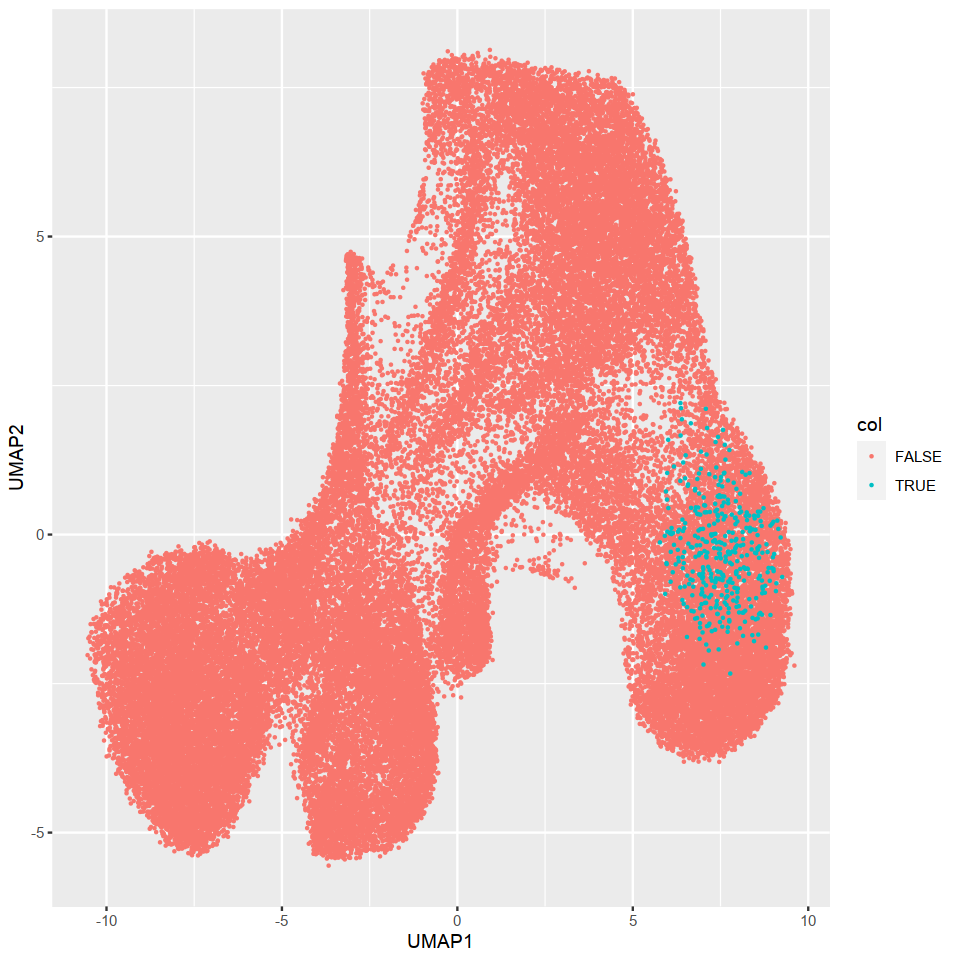

In [58]:
ggplot(umap_dims) + 
geom_point(aes(x=UMAP1, y=UMAP2, col=col), stroke=0, size=1)

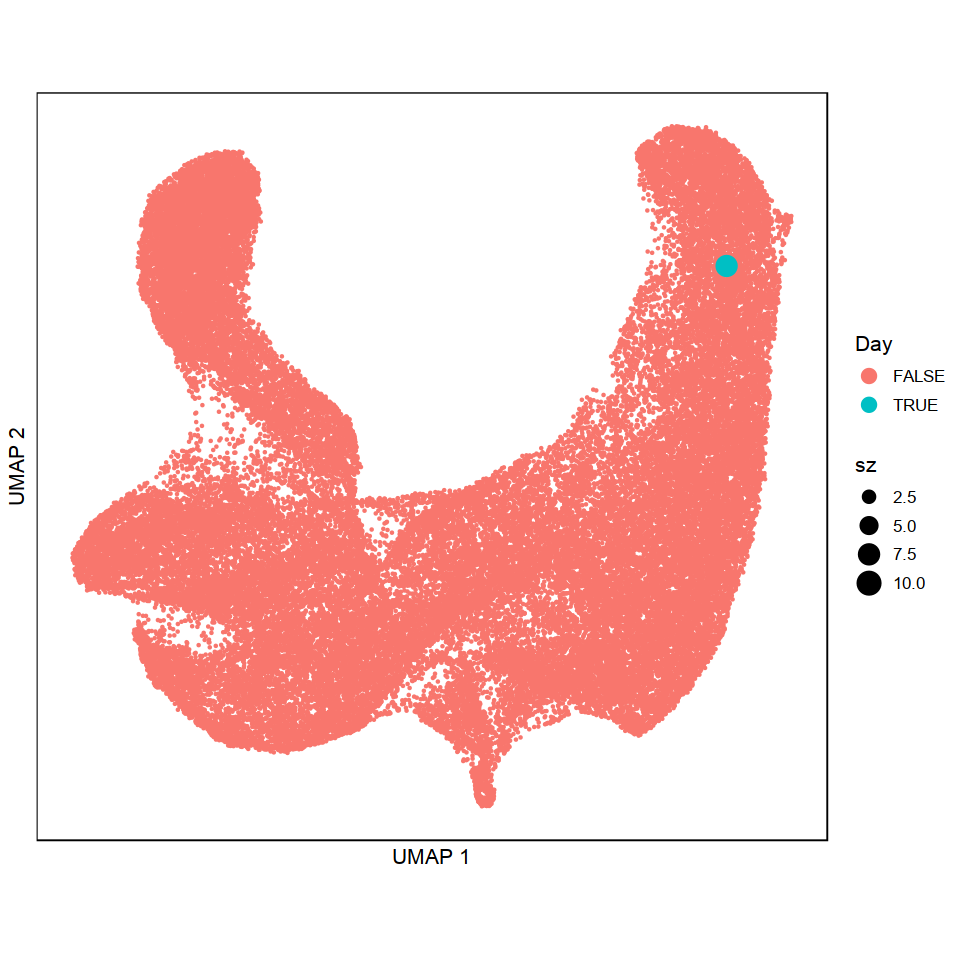

In [59]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna, reduction='umap'))$UMAP_2,
                 col=colnames(rna) %in% c(BARCODE))
plot_df$sz = ifelse(plot_df$col, 10, 1)
plot_df = plot_df[order(plot_df$sz), ]

by_day <- ggplot(plot_df) +
geom_point(aes(x=pc1, y=pc2, color=col, stroke=0, size=sz)) +
theme_classic() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
guides(colour = guide_legend(title="Day",
     override.aes = list(shape=16, alpha=1, size=4))) + 
coord_fixed()

by_day

In [60]:
archr_proj <- addPeak2GeneLinks(
    ArchRProj = archr_proj,
    reducedDims = "IterativeLSI"
)

ArchR logging to : ArchRLogs/ArchR-addPeak2GeneLinks-1e95695eedb1-Date-2020-11-13_Time-03-52-26.log
If there is an issue, please report to github with logFile!

2020-11-13 03:52:28 : Getting Available Matrices, 0.03 mins elapsed.

2020-11-13 03:52:37 : Filtered Low Prediction Score Cells (3597 of 53906, 0.067), 0.081 mins elapsed.

2020-11-13 03:52:42 : Computing KNN, 0.159 mins elapsed.

2020-11-13 03:52:43 : Identifying Non-Overlapping KNN pairs, 0.169 mins elapsed.

2020-11-13 03:52:45 : Identified 500 Groupings!, 0.205 mins elapsed.

2020-11-13 03:52:45 : Getting Group RNA Matrix, 0.206 mins elapsed.

2020-11-13 03:53:19 : Getting Group ATAC Matrix, 0.777 mins elapsed.

2020-11-13 03:54:29 : Normalizing Group Matrices, 1.947 mins elapsed.

2020-11-13 03:54:45 : Finding Peak Gene Pairings, 2.203 mins elapsed.

2020-11-13 03:54:45 : Computing Correlations, 2.214 mins elapsed.

2020-11-13 03:55:17 : Completed Peak2Gene Correlations!, 2.737 mins elapsed.

ArchR logging successful to : 

In [419]:
p2g <- getPeak2GeneLinks(
    ArchRProj = archr_proj,
    corCutOff = -1,
    FDRCutOff = 1e-04,
    resolution = 1,
    returnLoops = FALSE
)

In [422]:
sum(p2g$Correlation < -0.45)

[1] 27609

In [233]:
p2g

DataFrame with 646668 rows and 6 columns
         idxATAC    idxRNA        Correlation                  FDR
       <integer> <integer>          <numeric>            <numeric>
1             16         1  0.247726910455483 7.71995190386937e-08
2             31         1  0.247332985553687 8.12299362592615e-08
3             17         2 -0.213442265603076 4.65065177634272e-06
4             20         2 -0.253424694905799 3.65925977080608e-08
5             27         2  0.293971569828063 1.02852186603755e-10
...          ...       ...                ...                  ...
646664    413824     19207  0.186500844690941  7.3793364076165e-05
646665    413825     19208  0.251339772545591 4.81973191537968e-08
646666    413843     19209   0.18735986040544 6.79714275030079e-05
646667    413846     19209  0.237941236111429 2.66289084520201e-07
646668    413853     19209  0.187983327349924 6.40219512998132e-05
                VarQATAC            VarQRNA
               <numeric>          <numeric>


In [217]:
## peak_gene_ct["CTCFL"]

In [218]:
head(p2g@metadata[[1]])

GRanges object with 6 ranges and 0 metadata columns:
      seqnames      ranges strand
         <Rle>   <IRanges>  <Rle>
  [1]     chr1 10269-10885      *
  [2]     chr1 41989-42505      *
  [3]     chr1 46059-46558      *
  [4]     chr1 48201-48959      *
  [5]     chr1 51307-52190      *
  [6]     chr1 58645-59144      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [219]:
p2g@metadata[[2]][p2g$idxRNA]

GRanges object with 646668 ranges and 2 metadata columns:
           seqnames    ranges strand |      name     idx
              <Rle> <IRanges>  <Rle> |   <array> <array>
       [1]     chr1    817371      * |    FAM87B       1
       [2]     chr1    817371      * |    FAM87B       1
       [3]     chr1    825138      * | LINC01128       2
       [4]     chr1    825138      * | LINC01128       2
       [5]     chr1    825138      * | LINC01128       2
       ...      ...       ...    ... .       ...     ...
  [646664]     chrX 155334657      * |     CLIC2     694
  [646665]     chrX 155380787      * |    H2AFB1     695
  [646666]     chrX 155669944      * |     TMLHE     696
  [646667]     chrX 155669944      * |     TMLHE     696
  [646668]     chrX 155669944      * |     TMLHE     696
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

In [220]:
# write to file
p2g_df = data.frame(p2g)
peaks_to_write = (p2g@metadata[[1]][p2g$idxATAC])
start(peaks_to_write) = start(peaks_to_write) - 1 # adjusting to match bed file
p2g_df$peak = as.character(peaks_to_write)
p2g_df$gene = p2g@metadata[[2]][p2g$idxRNA]$name

p2g_df$idxATAC = NULL
p2g_df$idxRNA = NULL   

p2g_df = p2g_df[, c("peak", "gene", "Correlation", "FDR", "VarQATAC", "VarQRNA")]

head(p2g_df)

write.table(p2g_df, "./peak2gene_links/RNA_20200913_n59369/ATAC_20201022_n53906/20200925_all_fdr1e-4.tsv",
           sep='\t', quote=F, col.names=T, row.names=F)

peak               gene      Correlation FDR          VarQATAC  VarQRNA  
1 chr1:839897-840397 FAM87B     0.2477269  7.719952e-08 0.1893802 0.1702327
2 chr1:916486-917542 FAM87B     0.2473330  8.122994e-08 0.8509143 0.1702327
3 chr1:850279-850795 LINC01128 -0.2134423  4.650652e-06 0.5427712 0.4374512
4 chr1:857838-859165 LINC01128 -0.2534247  3.659260e-08 0.8104871 0.4374512
5 chr1:906668-907523 LINC01128  0.2939716  1.028522e-10 0.8878045 0.4374512
6 chr1:911064-912074 LINC01128  0.2201864  2.189101e-06 0.7773968 0.4374512

In [105]:
length(unique(p2g_df$gene))

[1] 12278

In [106]:
length(unique(p2g_df$peak))

[1] 57519

In [107]:
median(table(p2g_df$gene))

[1] 5

## Characterizing Positive and Negative Correlation Links

In [247]:
gene_sets = list()
for (i in seq(10)) {
    gene_sets[[i]] = as.character(read.table(sprintf("../20200828_RNA_Seurat/gene_sets/20201012_tmp_gridmap_znorm_n10/idx%d.txt", i))$V1)
}

In [342]:
gene_set_sizes = unlist(lapply(gene_sets, length))
gene_set_sizes

[1] 324 506 554 422 329 212 657 345 251 445

In [248]:
head(gene_sets[[1]])

[1] "HES4"    "ISG15"   "TNFRSF4" "MMP23B"  "GPR153"  "TNFRSF9"

In [328]:
top_pos_genes = p2g_df[p2g_df$Correlation>0.45, "gene"]
top_neg_genes = p2g_df[p2g_df$Correlation < -0.45, "gene"]

# top_pos_genes = p2g_df[rev(order(p2g_df$Correlation)), "gene"][1:10000]
# top_neg_genes = p2g_df[order(p2g_df$Correlation), "gene"][1:10000]

In [329]:
pos_tot = c()
neg_tot = c()

for (i in seq(10)){
    pos_tot = c(pos_tot, sum(top_pos_genes %in% gene_sets[[i]]))
    neg_tot = c(neg_tot, sum(top_neg_genes %in% gene_sets[[i]]))
}

In [338]:
pos_tot

[1] 2652 5524 7388 3570 2530  572 7127 1365 1768 4215

In [330]:
pos_tot/sum(pos_tot)

[1] 0.07223993 0.15047261 0.20124758 0.09724606 0.06891667 0.01558116
 [7] 0.19413800 0.03718232 0.04815995 0.11481572

In [331]:
neg_tot/sum(neg_tot)

[1] 0.032716731 0.125345113 0.233020431 0.021397018 0.003589177 0.004141358
 [7] 0.327581447 0.139149641 0.048039757 0.065019326

In [333]:
pos_tot
neg_tot

[1] 2652 5524 7388 3570 2530  572 7127 1365 1768 4215

[1]  237  908 1688  155   26   30 2373 1008  348  471

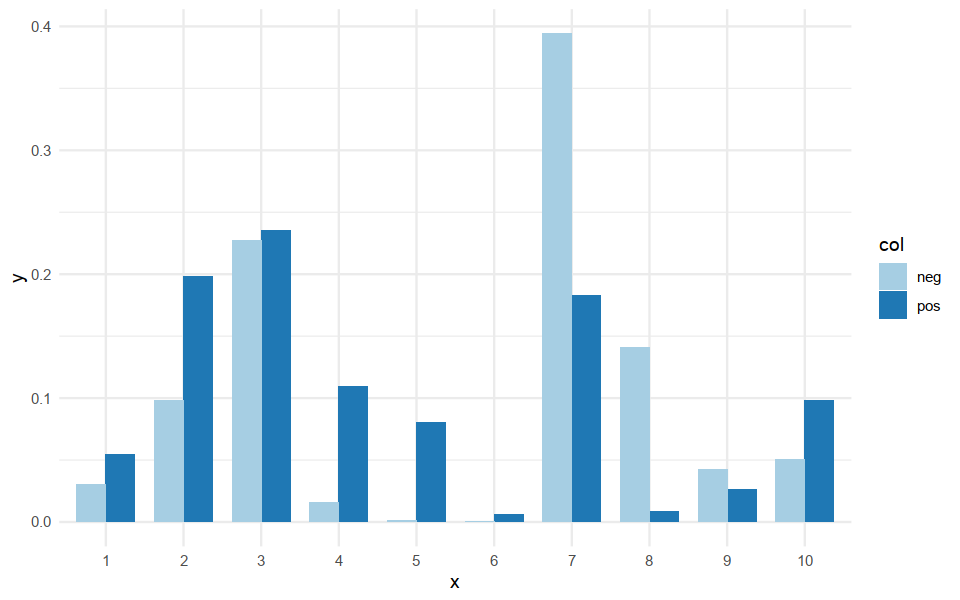

In [325]:
options(repr.plot.width = 8, repr.plot.height = 5)

ggplot(data.frame(x=factor(rep(seq(10),2)),
                 y=c(pos_tot/sum(pos_tot), neg_tot/sum(neg_tot)),
                 col = c(rep("pos", 10), rep("neg", 10))),
      aes(x=x,y=y, fill=col)) +
geom_bar(stat="identity", width=0.75, position=position_dodge()) +
a  scale_fill_brewer(palette="Paired")+
  theme_minimal()

In [345]:
pos_tot_adjust = 100*pos_tot/gene_set_sizes
neg_tot_adjust = 100*neg_tot/gene_set_sizes

In [377]:
quantile(as.vector(rna[["RNA"]]["OAS1"])[rna$sample != "D0"], .95)

95% 
0.978533

In [382]:
median(as.vector(rna[["RNA"]]["MYC"])[rna$sample != "D0"][as.vector(rna[["RNA"]]["OAS1"])[rna$sample != "D0"] > 1])

[1] 0

In [381]:
median(as.vector(rna[["RNA"]]["MYC"])[rna$sample != "D0"][as.vector(rna[["RNA"]]["OAS1"])[rna$sample != "D0"] < 1])

[1] 1.898708

In [416]:
head(rev(sort(table(top_neg_genes[top_neg_genes %in% unlist(gene_sets)]))), 100)


 SLC25A33    ISYNA1      TSR1      RRAS  SH3BGRL3     TCOF1     NINJ1  HSP90AB1 
       27        27        26        25        24        23        23        23 
  TMEM160     RRP1B      PVT1       MYC      IL34    SNRPA1     MTFP1     CMSS1 
       22        22        22        22        21        20        20        20 
   MRPS23     VAMP8    PCOLCE     MED15   LAPTM4B     FCGRT       DDT     RPL12 
       19        18        18        18        18        18        18        17 
     RCC2   FAM207A      DCP2     CCND1  SERPINB9    SCNN1A    NEURL1     MXRA8 
       17        17        17        17        16        16        16        16 
     LRP8     KDM1A     HOXB5      EMP3     CDCA5     WDR43      USP7      RMI2 
       16        16        16        16        16        15        15        15 
    PARVB       MIF     HOXB6     FADS1      ETV4     EPPK1     CENPV  C19orf33 
       15        15        15        15        15        15        15        15 
  AKIRIN1    A4GALT    TIMM

In [425]:
head(rev(sort(table(top_neg_genes[top_neg_genes %in% gene_sets[[7]]]))), 50)


   ISYNA1  HSP90AB1   TMEM160      PVT1      IL34    MRPS23     MED15   LAPTM4B 
       27        23        22        22        21        19        18        18 
      DDT     RPL12      RCC2   FAM207A      DCP2  SERPINB9    NEURL1      LRP8 
       18        17        17        17        17        16        16        16 
    KDM1A     PARVB       MIF      ETV4     EPPK1  C19orf33    A4GALT    TIMM8B 
       16        15        15        15        15        15        15        14 
    SUSD2  PPARGC1B      JAG1     ITGB2      GCH1  SLC39A10     SALL4    POU5F1 
       14        14        14        14        14        13        13        13 
     DFFA    TYMSOS     TPST2     SNHG4    SCARB1     RPS28     RPS23     RPS12 
       13        12        12        12        12        12        12        12 
    REEP6     PTAR1 LINC01260   GNPNAT1      DENR      CNBP     CDCA7 TTC28-AS1 
       12        12        12        12        12        12        12        11 
   SPINT2   SELENOW 
      

In [417]:
table(top_neg_genes)["SALL4"]
table(top_pos_genes)["SALL4"]

SALL4 
   13

SALL4 
   14

In [369]:
cor(as.vector(rna[["RNA"]]["COL1A1"])[rna$sample == "D2"], 
    as.vector(rna[["RNA"]]["MYC"])[rna$sample == "D2"])

[1] -0.4109809

In [383]:
subset = c(1,2,3,7,8,9,10)
pos_tot_adjust[subset]/sum(pos_tot_adjust[subset])
neg_tot_adjust[subset]/sum(neg_tot_adjust[subset])

[1] 0.12837901 0.17122559 0.20916193 0.17014019 0.06205533 0.11047755 0.14856041

[1] 0.05026890 0.12331940 0.20939135 0.24821523 0.20078788 0.09527996 0.07273726

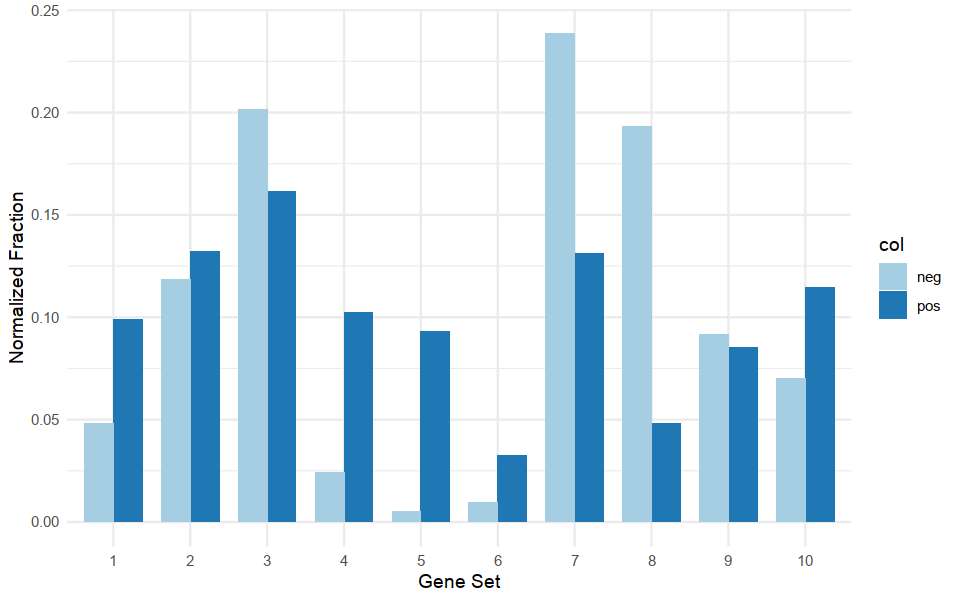

In [424]:
options(repr.plot.width = 8, repr.plot.height = 5)

ggplot(data.frame(x=factor(rep(seq(10),2)),
                 y=c(pos_tot_adjust/sum(pos_tot_adjust), neg_tot_adjust/sum(neg_tot_adjust)),
                 col = c(rep("pos", 10), rep("neg", 10))),
      aes(x=x,y=y, fill=col)) +
xlab("Gene Set") + ylab("Normalized Fraction") +
geom_bar(stat="identity", width=0.75, position=position_dodge()) +
  scale_fill_brewer(palette="Paired")+
  theme_minimal()

In [251]:
length(top_pos_genes)

[1] 93001

---

In [108]:
head(rev(sort(table(p2g$idxATAC))))


378240 378248 378252 378231 337478 337475 
    15     14     13     13     13     13 

In [109]:
head(p2g@metadata[[2]])

GRanges object with 6 ranges and 2 metadata columns:
      seqnames    ranges strand |      name     idx
         <Rle> <IRanges>  <Rle> |   <array> <array>
  [1]     chr1    817371      * |    FAM87B       1
  [2]     chr1    825138      * | LINC01128       2
  [3]     chr1    827522      * | LINC00115       3
  [4]     chr1    876903      * |    FAM41C       4
  [5]     chr1    919692      * | LINC02593       5
  [6]     chr1    924880      * |    SAMD11       6
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

In [115]:
head(rev(sort(table(p2g_df$gene))), 30)


  COL6A3     MLPH   SEMA6A    PARVA    FOXF1    SMAD3    GCNT2    TNNI3 
      66       50       49       49       49       48       48       47 
    DKK3     TBX2     NAV1   FENDRR   MICAL2     JPH1  ZFP36L1     EXT1 
      47       45       44       44       43       43       42       42 
  UNC93A   TNFSF9      TNC TBX2-AS1  SLC39A4    FOXL1     UGT8    IL1R1 
      41       40       40       40       40       40       39       39 
  COL1A1   ZNF486   TUBB4A  ST6GAL1     RYR1     RXRA 
      39       38       38       38       38       38 

In [117]:
table(p2g@metadata[[2]][p2g$idxRNA]$name)["JAKMIP"]

MAP2 
  26

In [139]:
getPeak2GeneLinks(archr_proj)[[1]][queryHits(findOverlaps(getPeak2GeneLinks(archr_proj)[[1]], 
                                                          GRanges(c("chr12:7787794-7799141"))))]

GRanges object with 82 ranges and 2 metadata columns:
       seqnames          ranges strand |             value                  FDR
          <Rle>       <IRanges>  <Rle> |         <numeric>            <numeric>
   [1]    chr12 7667500-7891500      * |  0.55062494438884 2.68719331246967e-39
   [2]    chr12 7677500-7891500      * | 0.482594892547855 3.98821626156944e-29
   [3]    chr12 7678500-7891500      * | 0.497486498708443 3.69684621111592e-31
   [4]    chr12 7679500-7891500      * | 0.472772419885563 7.71042634745979e-28
   [5]    chr12 7693500-7891500      * | 0.594741248489826 2.85581593073272e-47
   ...      ...             ...    ... .               ...                  ...
  [78]    chr12 7787500-7982500      * | 0.468881731262359 2.42567986427967e-27
  [79]    chr12 7787500-8018500      * | 0.512509915437053 2.57785107855091e-33
  [80]    chr12 7787500-8019500      * | 0.664463158153499 9.80223350748262e-63
  [81]    chr12 7789500-7891500      * | 0.639733572190767 8.69238

In [100]:
p <- plotPeak2GeneHeatmap(ArchRProj = archr_proj, groupBy = "Clusters")

ArchR logging to : ArchRLogs/ArchR-plotPeak2GeneHeatmap-732172634f49-Date-2020-09-23_Time-12-19-52.log
If there is an issue, please report to github with logFile!

2020-09-23 12:20:04 : Determining KNN Groups!, 0.198 mins elapsed.

2020-09-23 12:20:19 : Ordering Peak2Gene Links!, 0.448 mins elapsed.

Warning message:
“did not converge in 10 iterations”
2020-09-23 12:22:15 : Constructing ATAC Heatmap!, 2.384 mins elapsed.

Adding Annotations..

Preparing Main Heatmap..

2020-09-23 12:22:17 : Constructing RNA Heatmap!, 2.414 mins elapsed.

Adding Annotations..

Preparing Main Heatmap..

ArchR logging successful to : ArchRLogs/ArchR-plotPeak2GeneHeatmap-732172634f49-Date-2020-09-23_Time-12-19-52.log



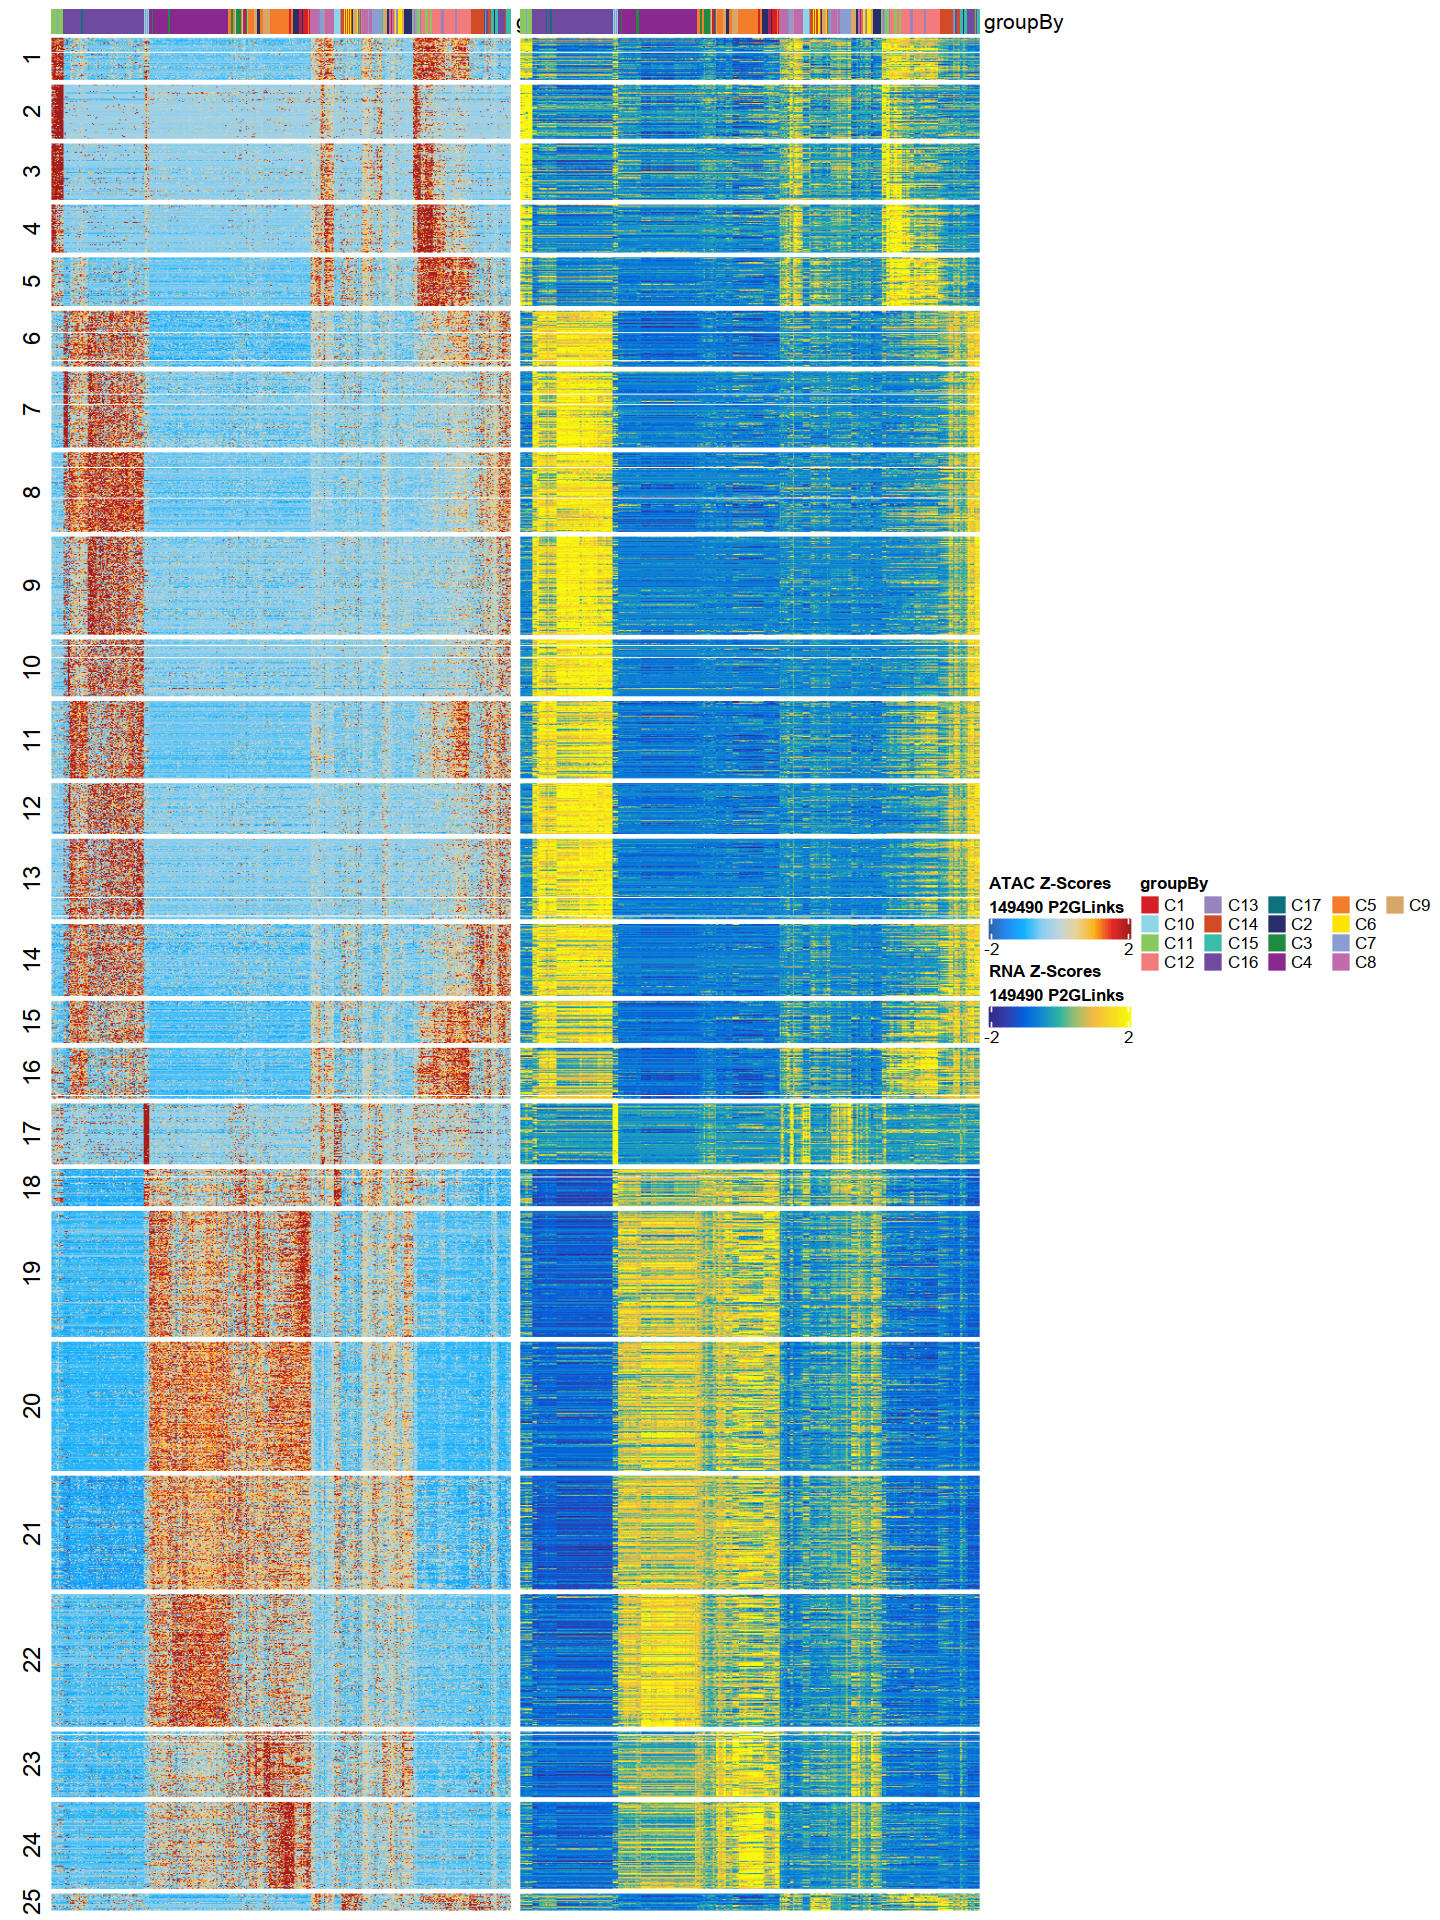

In [102]:
options(repr.plot.width = 12, repr.plot.height = 16)

p

In [258]:
p2g@metadata[[1]]

GRanges object with 803958 ranges and 1 metadata column:
           seqnames            ranges strand |  peak_set
              <Rle>         <IRanges>  <Rle> | <numeric>
       [1]     chr1       10506-10717      * |         0
       [2]     chr1       42146-42371      * |         0
       [3]     chr1       46218-46443      * |         0
       [4]     chr1       48626-48825      * |         0
       [5]     chr1       51437-51661      * |         0
       ...      ...               ...    ... .       ...
  [803954]     chrY 25399178-25399400      * |         0
  [803955]     chrY 26315152-26315361      * |         0
  [803956]     chrY 26409423-26409622      * |         0
  [803957]     chrY 26671003-26671239      * |         0
  [803958]     chrY 26671290-26671489      * |         0
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [287]:
p2g@metadata[[1]]$peak_set = 0
all_peak_str = as.character(p2g@metadata[[1]]) # sorted version of peak_set

for (i in seq(40)) {
    cur_peak_set = import(sprintf("../20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40/idx%d.bed", i))
    p2g@metadata[[1]][all_peak_str %in% as.character(cur_peak_set)]$peak_set = i
}

In [514]:
SELECT_PEAK_SETS = c(33,34,35)

In [515]:
idxs = which(p2g@metadata[[1]]$peak_set %in% SELECT_PEAK_SETS)

In [516]:
length(idxs)

[1] 41689

In [517]:
sum(p2g$idxATAC %in% idxs)

[1] 10289

In [518]:
p2g@metadata[[2]][p2g[p2g$idxATAC %in% idxs, ][rev(order(p2g[p2g$idxATAC %in% idxs, ]$Correlation)),]$idxRNA]

GRanges object with 10289 ranges and 2 metadata columns:
          seqnames    ranges strand |    name     idx
             <Rle> <IRanges>  <Rle> | <array> <array>
      [1]     chr1 161038962      * |    F11R    1365
      [2]     chr3  11137093      * |    HRH1      61
      [3]    chr17  48593961      * |   HOXB5     698
      [4]    chr17  48604992      * |   HOXB6     696
      [5]     chr2 238848032      * |  TWIST2    1244
      ...      ...       ...    ... .     ...     ...
  [10285]     chr7  24758113      * |   GSDME     126
  [10286]    chr10  97334709      * |   FRAT2     494
  [10287]     chr1 109283186      * |   PSRC1     949
  [10288]    chr16    684528      * |   JMJD8      37
  [10289]     chr5  38608354      * |    LIFR     124
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

In [519]:
cor_genes = rev(sort(table(p2g@metadata[[2]][p2g[p2g$idxATAC %in% idxs, ]$idxRNA]$name)))
length(cor_genes)
head(cor_genes, 20)

[1] 4528


    GAMT   MALAT1   FAM89B CDC42EP2    MXRA8   SHKBP1   LGALS1    ERCC1 
      24       17       17       16       15       14       14       14 
   CIRBP  CCDC85B  TRAPPC1    LZTS2     LMNA     FIBP    TIMP2   SORBS3 
      14       14       13       13       13       13       12       12 
  PDLIM2    NEAT1     LTBR    GAPDH 
      12       12       12       12 

In [520]:
# genes ranked by correlation to their linked peak
# cor_genes_by_cor = p2g[p2g$idxATAC %in% idxs, ]
# cor_genes_by_cor = p2g@metadata[[2]][cor_genes_by_cor[rev(order(cor_genes_by_cor$Correlation)),]$idxRNA]$name
# cor_genes_by_cor = unique(cor_genes_by_cor)
# length(cor_genes_by_cor)
# head(cor_genes_by_cor, 10)

In [521]:
sum(cor_genes>1)

[1] 2312

In [524]:
cor_genes["CTCFL"]

CTCFL 
    1

In [513]:
write.table(names(cor_genes)[1:2000], "tmp.txt", quote=F, row.names=F, col.names=F)

In [478]:
# load bulk RNA-seq data
fpkm = read.table("/users/surag/kundajelab/scATAC-reprog/resources/GSE62777/RNAseq.FPKM.tsv", sep='\t', header=T)
fpkm$gene_id = NULL
fpkm$locus=NULL
tpm = fpkm
tpm[,2:ncol(tpm)] = 1e6*t(t(tpm[,2:ncol(tpm)])/colSums(tpm[,2:ncol(tpm)]))

# removing genes with dup names
tpm = tpm[!duplicated(tpm$gene_short_name),]
rownames(tpm) = tpm$gene_short_name
tpm$gene_short_name = NULL

tpm["GAPDH",]

hiF.T_P14 X2dd_DOX_plus X5dd_DOX_plus X8dd_DOX_plus
GAPDH 7803.64   4963.505      3908.693      3839.776     
      X10dd_DOX_plus_SSEA3_pos X14dd_DOX_plus_SSEA3_pos X20dd_DOX_plus_TRA_plus
GAPDH 3795.548                 3364.503                 3032.412               
      X24dd_TRA_pos_DOX_plus X24dd_TRA_pos_DOX_minus hIPSC.T_P10
GAPDH 3790.955               5598.224                4731.256

Warning message in melt(as.matrix(log2(1 + tpm)[rownames(tpm) %in% cor_genes_by_cor[1:100], :
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(as.matrix(log2(1 + tpm)[rownames(tpm) %in% cor_genes_by_cor[1:100],     ])). In the next version, this warning will become an error.”


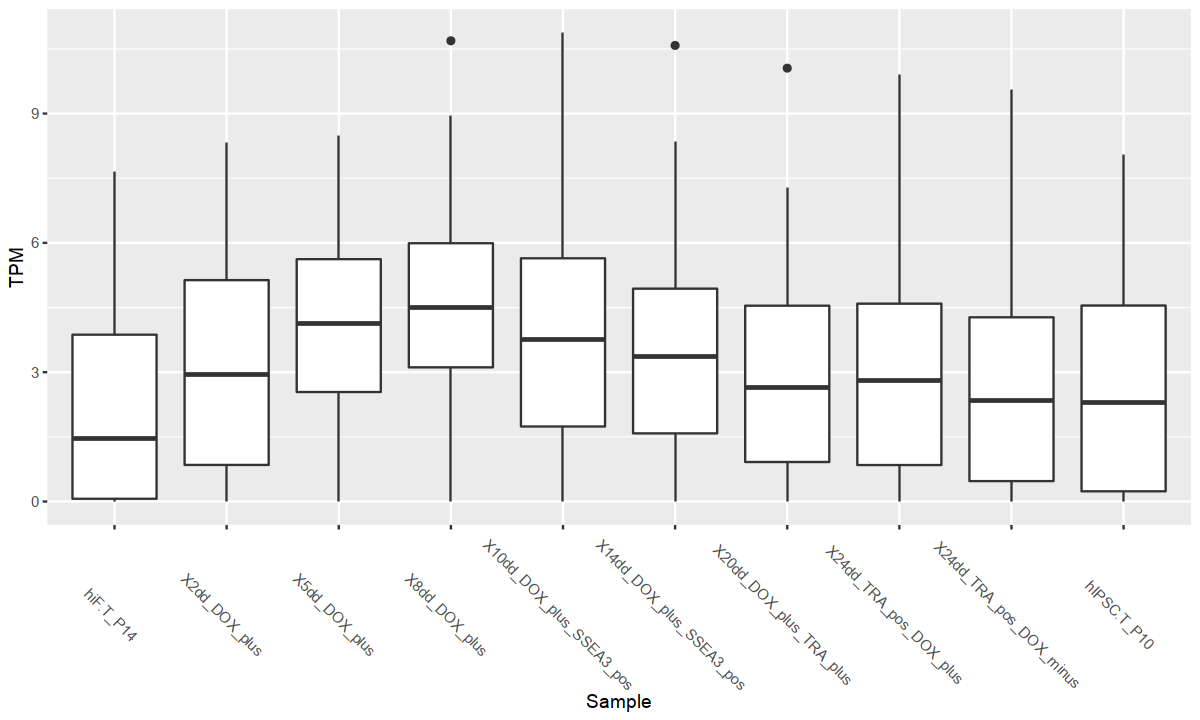

In [498]:
options(repr.plot.width = 10, repr.plot.height = 6)

ggplot(melt(as.matrix(log2(1+tpm)[rownames(tpm) %in% names(cor_genes)[1:100], ])), aes(x=Var2, y=value)) +
# ggplot(melt(t(scale(t(log2(1+tpm)[rownames(tpm) %in% names(cor_genes)[1:100], ])))), aes(x=Var2, y=value)) +
stat_boxplot() +
# geom_line(aes(group=Var1),size=0.1) + geom_point() +
theme(axis.text.x = element_text(angle = -45)) +
ylab("TPM") + xlab("Sample")
# geom_boxplot(outlier.shape = NA) + geom_jitter(width = 0.2)
# coord_cartesian(ylim=c(0,8))